In [67]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.stats import normaltest
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

In [68]:
# input_path = r"C:\Users\phamhoa\Downloads\thesis\data\Binance\agg\500\VPIN"
input_path = "/Users/hoapham/Documents/Learning/thesis/data/Binance/agg/500/VPIN"
symbol = "BNBUSDT"
df = pd.read_csv(f"{input_path}/{symbol}.csv")
try:
    df = df.drop(columns=["Unnamed: 0"])
except:
    pass
df['Time'] = pd.to_datetime(df['Time'])

In [69]:
df.tail()

,Time,Buy,Sell,Price,BidPrice,AskPrice,Volumn,VPIN,CDF
632,2025-09-06 03:44:24+00:00,2044.705558,1311.294442,858.377442,858.444184,858.273370,3356.0,0.153843,0.801020
633,2025-09-06 04:04:29+00:00,1595.687000,1760.313000,859.023810,859.150403,858.909056,3356.0,0.152954,0.790816
634,2025-09-06 04:31:45+00:00,2023.063992,1332.936008,858.862635,858.915534,858.782347,3356.0,0.153817,0.799320
635,2025-09-06 04:49:39+00:00,1810.571153,1545.428847,857.136780,856.992857,857.305396,3356.0,0.149545,0.755102
636,2025-09-06 05:44:22+00:00,1440.601345,1915.398655,857.654130,857.670795,857.641596,3356.0,0.147919,0.727891


In [70]:
df.columns

Index(['Time', 'Buy', 'Sell', 'Price', 'BidPrice', 'AskPrice', 'Volumn',
       'VPIN', 'CDF'],
      dtype='object')

# PHÂN TÍCH ĐƠN BIẾN VPIN

### Thống kê mô tả

In [51]:
pd.DataFrame(df['VPIN'].describe()).T

,count,mean,std,min,25%,50%,75%,max
VPIN,588.0,0.14453,0.020364,0.111539,0.133056,0.140671,0.148856,0.214568


- Mẫu gồm 588 quan sát, khá đủ để phân tích thống kê.

- Giá trị trung bình ~0.1445 với độ lệch chuẩn ~0.0204, tức phân phối VPIN dao động nhẹ quanh mức trung bình, không quá phân tán.

- Khoảng biến thiên: từ 0.1115 (min) đến 0.2146 (max) → độ chênh lệch không quá lớn, cho thấy VPIN nằm trong một biên độ tương đối hẹp.

- Phân vị 25% (0.1331), 50% (0.1407), 75% (0.1489) khá sát nhau → dữ liệu tập trung mạnh quanh median, ít cực đoan.

- Có một vài giá trị cao (max 0.2146) xa hơn mức trung bình nhiều, gợi ý khả năng tồn tại outlier hoặc giai đoạn thị trường biến động mạnh.

### Biểu đồ phân bố

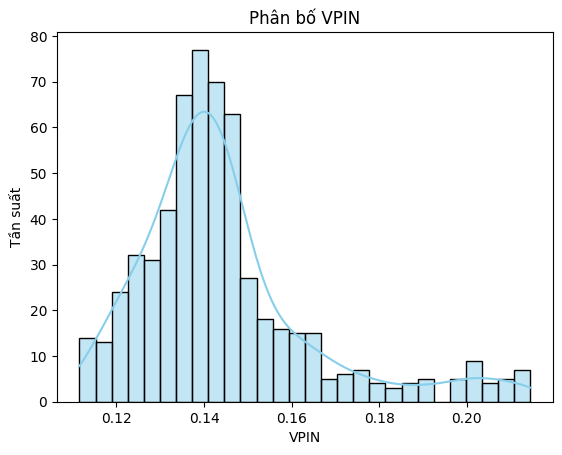

In [52]:

sns.histplot(df['VPIN'], kde=True, color='skyblue')
plt.title('Phân bố VPIN')
plt.xlabel('VPIN')
plt.ylabel('Tần suất')
plt.show()


- Biểu đồ phân bố VPIN cho thấy:

    - Dữ liệu tập trung chủ yếu quanh vùng 0.13 – 0.15, với đỉnh tần suất cao nhất gần 0.14, đúng với median và mean trong bảng thống kê trước.

    - Phân phối có đuôi phải kéo dài (right-skewed), tức tồn tại nhiều giá trị cao bất thường (trên 0.18–0.20). Đây có thể là tín hiệu của những giai đoạn thị trường có dòng lệnh mất cân đối.

    - Phần lớn quan sát nằm trong biên hẹp, cho thấy VPIN thường ổn định, nhưng các đỉnh nhỏ ở vùng 0.20+ phản ánh những trường hợp ngoại lai hoặc trạng thái căng thẳng.

    - Đường mật độ mượt (KDE) cũng cho thấy một phân phối lệch phải nhẹ thay vì chuẩn đối xứng.

### Vẽ biểu đồ hộp - Boxplot

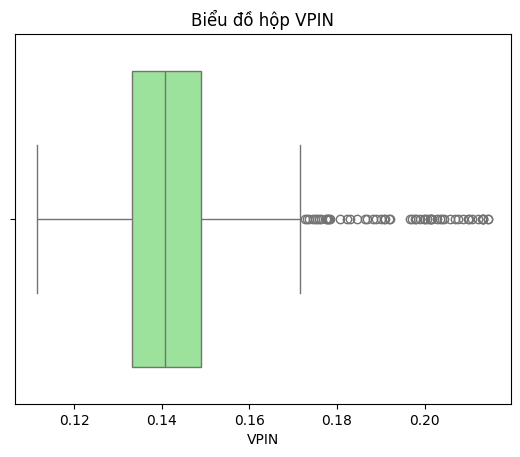

In [53]:
sns.boxplot(x=df['VPIN'], color='lightgreen')
plt.title('Biểu đồ hộp VPIN')
plt.xlabel('VPIN')
plt.show()

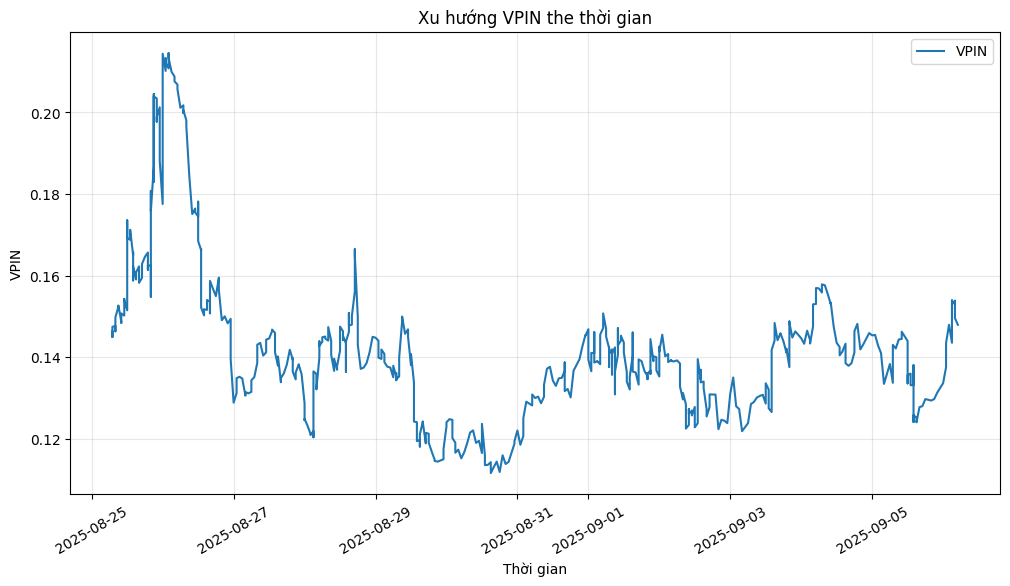

In [54]:
def plot_vpin(buckets, col):
    plt.figure(figsize=(12,6))
    plt.plot(buckets["Time"].dt.floor('h'), buckets[col], label=f'{col}', linewidth=1.5)
    plt.title(f"Xu hướng {col} the thời gian")
    plt.xlabel("Thời gian")
    plt.ylabel(col)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=30)
    plt.show()
plot_vpin(df, "VPIN")


### Kiểm tra phân phối của dữ liệu VPIN

- Giả thuyết H0: Dữ liệu VPIN tuân theo phân phối chuẩn
- Giả thuyết H1: Dữ liệu không tuân theo phân phối chuẩn.

In [55]:
stat, p = shapiro(df['VPIN'].dropna())
print(f'Shapiro-Wilk test: p-value = {p}')


Shapiro-Wilk test: p-value = 1.0419059844904948e-21


In [56]:
stat, p = shapiro(np.log(df['VPIN'].dropna()))
p

np.float64(9.266174796837868e-17)

# Tính toán các Biến mục tiêu

In [57]:
# Cửa sổ
window = 50

## 1. Bid-Ask Spread


In [71]:
df['BidAskSpread'] = df['AskPrice'] - df['BidPrice']
df['SpreadChangeSign'] = np.sign(df['BidAskSpread'].diff())


### Tính lợi suất (Returns) từ giá trung bình

In [74]:
df['Returns'] = df['Price'].pct_change()

### Tính biến động giá (Volatility) - Rolling Standard Deviation

In [86]:

df['RealizedVolatility'] = df['Returns'].rolling(window=window).std()
df['RealizedVolatilitySign'] = np.sign(df['RealizedVolatility'].diff())

# Tính Skewness và Kurtosis

In [76]:

df['Skewness'] = df['Returns'].rolling(window=window).apply(skew)
df['Kurtosis'] = df['Returns'].rolling(window=window).apply(kurtosis)


In [79]:
def jarque_bera_statistic(skewness, kurtosis, n):
    # Tính Jarque-Bera Statistic theo công thức
    return (n / 6) * (skewness**2 + ((kurtosis - 3)**2) / 4)

In [82]:
df['JB_rolling'] = df.apply(lambda row: jarque_bera_statistic(
    row['Skewness'],
    row['Kurtosis'],
    window
    )
    if not np.isnan(row['Skewness']) else np.nan, axis=1)

In [84]:
df['JB_ChangeSign'] = np.sign(df['JB_rolling'].diff())

## Dấu sự thay đổi trong tự tương quan bậc nhất

In [88]:
df['AR'] = df['Returns'].rolling(window=window).apply(lambda x: x.autocorr(lag=1), raw=False)
df['AR_ChangeSign'] = np.sign(df['AR'].diff())


# Tính bình thường (Normality) – kiểm định Jarque-Bera hoặc D’Agostino

In [62]:

df['Normality_p'] = df['Returns'].rolling(window=50).apply(lambda x: normaltest(x)[1] if len(x.dropna()) >= 8 else np.nan)


# Phân tích mối quan hệ giữa VPIN và các biến mục tiêu

In [63]:
correlation_matrix = df[['VPIN', 'Volatility', 'Skewness', 'Kurtosis', 'Normality_p']].corr()
correlation_matrix

,VPIN,Volatility,Skewness,Kurtosis,Normality_p
VPIN,1.000000,0.262038,0.092531,-0.195096,0.331160
Volatility,0.262038,1.000000,0.409182,0.053425,0.317885
Skewness,0.092531,0.409182,1.000000,-0.177377,0.150690
Kurtosis,-0.195096,0.053425,-0.177377,1.000000,-0.443357
Normality_p,0.331160,0.317885,0.150690,-0.443357,1.000000


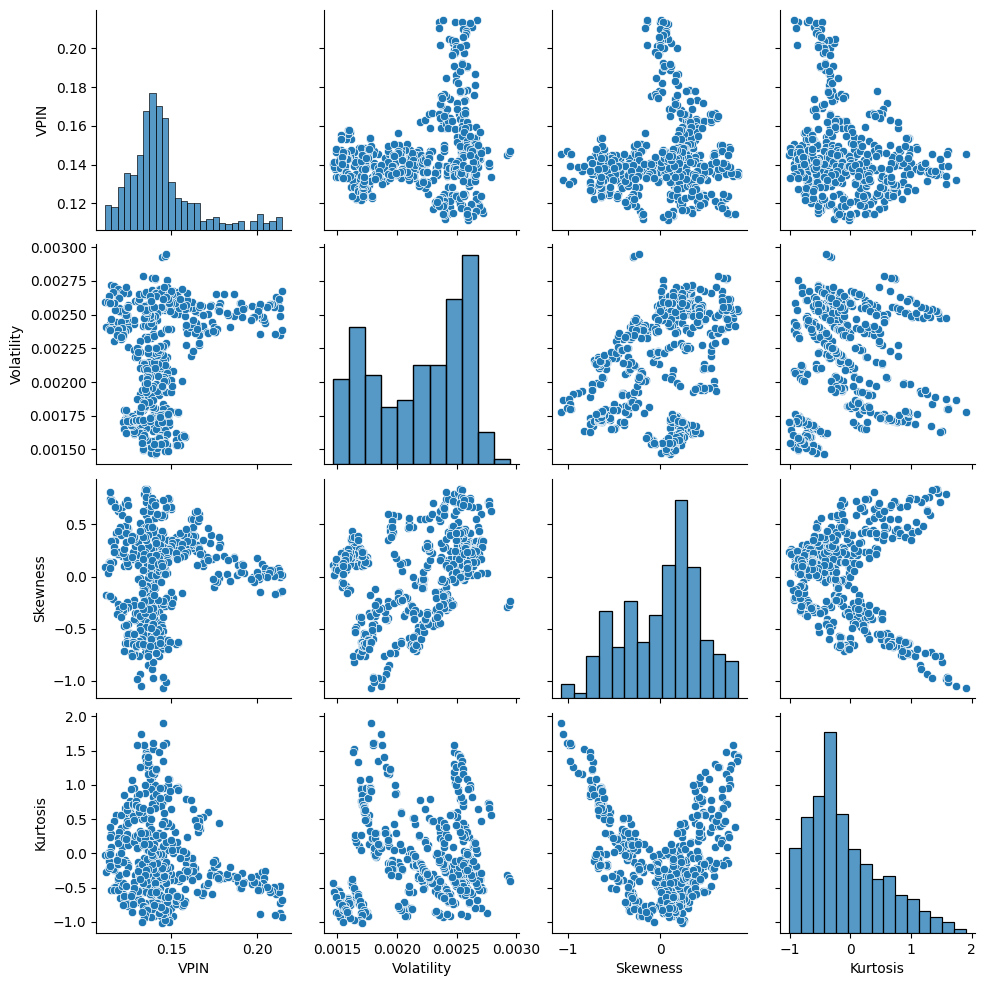

In [64]:
sns.pairplot(df[['VPIN', 'Volatility', 'Skewness', 'Kurtosis']])

# Tính ROLL
$$
\text{Spread} = 2 \times \sqrt{|\text{Cov}(\Delta P_{\tau}, \Delta P_{\tau-1})|}
$$


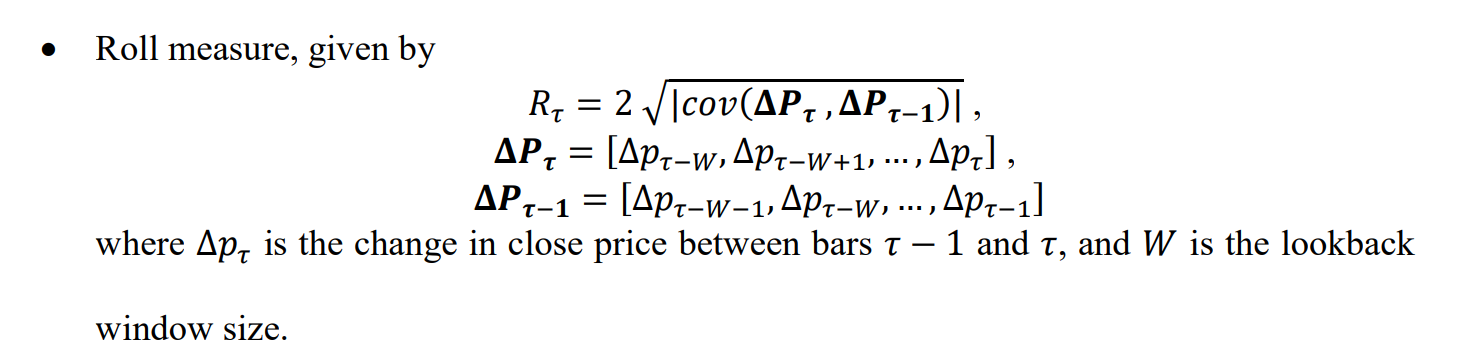

In [65]:
def roll_measure(DeltaPriceSeries):
    x = DeltaPriceSeries[1:] # delta P_t
    y = DeltaPriceSeries[:-1] # delta P_{t-1}
    cov = x.cov(y)
    return 2*np.sqrt(abs(cov))
df["DeltaPrice"] = df['Price'].diff()
# Vì theo công thức và ghi chú, đang rolling trên DeltaPrice, nên sẽ dùng DeltaPrice để tính ROLL với window = 50
df["RollMeasure"] = df["DeltaPrice"].rolling(window=50).apply(roll_measure, raw=False) 
df.tail()

,Time,Buy,Sell,Price,BidPrice,AskPrice,Volumn,VPIN,CDF,Returns,Volatility,Skewness,Kurtosis,Normality_p,DeltaPrice,RollMeasure
632,2025-09-06 03:44:24+00:00,2044.705558,1311.294442,858.377442,858.444184,858.273370,3356.0,0.153843,0.801020,0.001201,0.001775,-0.639424,0.951642,0.042338,1.030038,3.074574
633,2025-09-06 04:04:29+00:00,1595.687000,1760.313000,859.023810,859.150403,858.909056,3356.0,0.152954,0.790816,0.000753,0.001776,-0.651813,0.954471,0.039488,0.646368,3.082314
634,2025-09-06 04:31:45+00:00,2023.063992,1332.936008,858.862635,858.915534,858.782347,3356.0,0.153817,0.799320,-0.000188,0.001778,-0.627685,0.922680,0.047030,-0.161175,3.034412
635,2025-09-06 04:49:39+00:00,1810.571153,1545.428847,857.136780,856.992857,857.305396,3356.0,0.149545,0.755102,-0.002009,0.001781,-0.627029,0.902320,0.048662,-1.725855,3.006962
636,2025-09-06 05:44:22+00:00,1440.601345,1915.398655,857.654130,857.670795,857.641596,3356.0,0.147919,0.727891,0.000604,0.001765,-0.694125,1.090313,0.025532,0.517350,3.050420


# Tính Roll impact

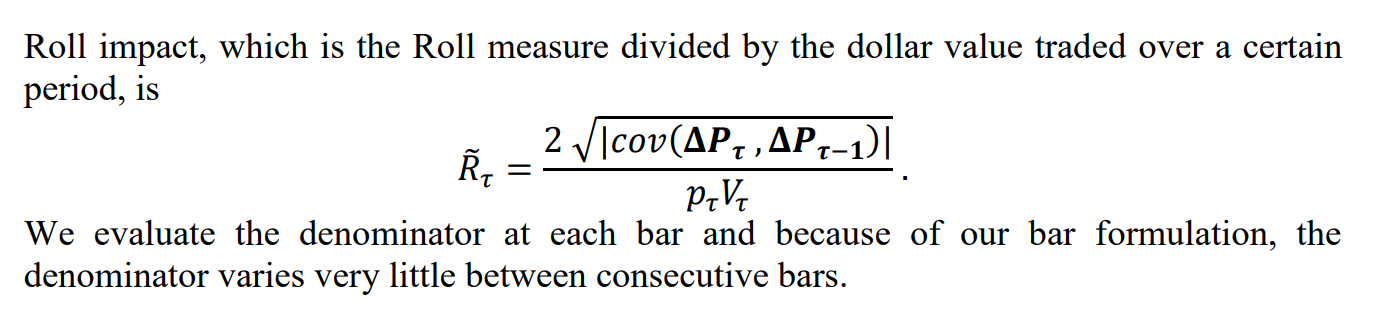